# Qiskit Coding Exercise: Solving Max-Cut with QAOA

This notebook is a hands-on exercise to implement the QAOA algorithm described in your notes. You will follow the 7-step process to define, solve, and verify the solution for a classical Max-Cut problem. The following tasks are set as simplest as possible to avoid any heavy jargon and confusion. This coding exercise aim to explain the process by simulating through simple codes.

## Setup: Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph

from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Estimator, Sampler

from qiskit_algorithms.optimizers import COBYLA

--- 

## Task 1: Define the Problem (The Graph)

### 1. Engage (Why?)
We start with a classical optimization problem. The Max-Cut problem is the "Hello, World!" of quantum optimization. Our goal is to find a way to partition the nodes of a graph into two sets (0 and 1) to *maximize* the number of edges connecting the two sets.

### 2. Explore (Play)
Let's use a simple 5-node graph with 6 edges. We can draw it to visualize.



### 3. Explain (The Concept)
We can create this graph using the `rustworkx` library. The nodes will be labeled 0, 1, 2, 3 and 4.

### 4. Elaborate (Apply)
Run the code below to create and draw our problem graph.

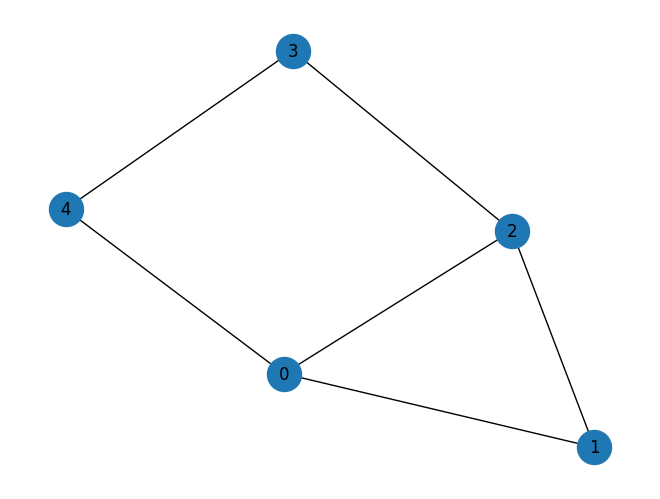

In [17]:
n = 5

graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
edge_list = [
    (0, 1, 1.0),
    (0, 2, 1.0),
    (0, 4, 1.0),
    (1, 2, 1.0),
    (2, 3, 1.0),
    (3, 4, 1.0),
]
graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

### 5. Evaluate (Verification)

Before we use a quantum computer, **what is the *classical* solution?** 

Look at the graph. A bitstring like `00000` or `11111` gives 0 cuts (bad solution).
A bitstring like `10100` puts nodes 0, 1 and 3 in set '0' and nodes 2 and 4 in set '1'. This cuts 5 edges. This is a probable optimal solution.

**Note**: our notation of bitstrings now follows qiskit notation `q4q3q2q1q0`

**Ground Truth (Optimal Solutions):**

Our goal is to make the QAOA algorithm return the optimal solutions

--- 

## Task 2: Create the Cost Hamiltonian $H_P$

### 1. Engage (Why?)
Now we translate our classical graph into a quantum physics problem. We will build the Cost Hamiltonian $H_P$.

### 2. Explain (The Concept)
As derived in your notes, the Cost Hamiltonian for Max-Cut is $H_P = \sum_{(i, j) \in \text{edges}} Z_i Z_j$. 

We will build this operator using Qiskit's `SparsePauliOp` class. We loop through each edge in our graph `graph` and add a 'ZZ' term for that edge.

For our 5-qubit graph, the edges are `(0, 1)`, `(0, 2)`, `(0, 4)`, `(1, 2)`, `(2, 3)`, and `(3, 4)`. The `SparsePauliOp` list will be: `['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII']`. (Remember, Qiskit orders qubits from right to left `q4q3q2q1q0`).

In [9]:
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list.

    This function does the inverse of `build_max_cut_graph`
    """
    pauli_list = []
    for edge in list(graph.edge_list()):
        weight = graph.get_edge_data(edge[0], edge[1])
        pauli_list.append(("ZZ", [edge[0], edge[1]], weight))
    return pauli_list


max_cut_paulis = build_max_cut_paulis(graph)
cost_hamiltonian = SparsePauliOp.from_sparse_list(max_cut_paulis, n)
print("Cost Function Hamiltonian:", cost_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


### 3. Evaluate (Verify with Simulation)
Let's verify this Hamiltonian is correct *before* we build the algorithm. We can use the `Estimator` primitive to check the energy of our known good and bad solutions.

**Your Task:** Create two circuits, one for a bad solution (`'00000'`) and one for a good solution (`'10100'`). Then, use the `Estimator` to find the cost (energy) of each. 

*(Remember to apply X gates to create the $|1\rangle$ states for `'10100'`).*

In [ ]:
# --- Your Code Here ---

# 1. Create the 'bad' circuit (00000) - No cuts
# An empty circuit on n=5 qubits naturally prepares the |00000> state
qc_bad = QuantumCircuit(n) 

# 2. Create the 'good' circuit (10100) - Optimal cut
# We want the state |10100> in Qiskit (little-endian).
# q0 = 0, q1 = 0, q2 = 1, q3 = 0, q4 = 1
qc_good = QuantumCircuit(n)
qc_good.x(2) # Flip q2 to |1>
qc_good.x(4) # Flip q4 to |1>

# 3. Instantiate an Estimator (V1)
estimator = Estimator()              # local, ideal reference estimator
job = estimator.run(circuits=[qc_bad, qc_good], observables=[cost_hamiltonian, cost_hamiltonian])
res = job.result()
print("Estimator results (expectation values):", res.values)  # list of floats

# 4. Run the Estimator via local V1
pub_bad = (qc_bad, cost_hamiltonian)
pub_good = (qc_good, cost_hamiltonian)

job = estimator.run(
    circuits=[qc_bad, qc_good],
    observables=[cost_hamiltonian, cost_hamiltonian]
)
result = job.result()

# 5. Extract results
cost_bad, cost_good = result.values

print(f"Energy of '00000' (Bad): {cost_bad}")
print(f"Energy of '10100' (Good): {cost_good}")

# --- End Your Code ---

Estimator results (expectation values): [ 6. -4.]
Energy of '00000' (Bad): 6.0
Energy of '00101' (Good): -4.0


**Analysis:**  
For the bad solution (e.g. `00000`), all vertices lie in the same partition, so no edges are cut. All 6 edges are uncut and each contributes $+1$, giving a total energy of $+6.0$.

For the good solution (e.g. `10100`, corresponding to the partition {0,1,3} and {2,4}), 5 out of the 6 edges are cut. Cut edges contribute $−1$ and the single uncut edge contributes $+1$, resulting in a total energy of $−4.0$.

This is the minimum possible energy for this graph, confirming that the Cost Hamiltonian correctly encodes the Max-Cut objective: lower energy corresponds to a larger cut size. 


--- 

## Task 3: Build the QAOA Ansatz $U(\vec{\theta})$

### 1. Engage (Why?)
Now we build the parameterized quantum circuit (the Ansatz). This circuit will be trained to *find* the ground state of $H_P$.

### 2. Explain (The Concept)
As defined in your notes, the ansatz is built from $p$ layers of the Cost Layer and the Mixer Layer.
* **Cost Layer:** $U_P(\gamma_i) = \prod e^{-i\gamma_i Z_i Z_j}$ -> `qc.rzz(2 * gamma, i, j)`
* **Mixer Layer:** $U_M(\beta_i) = \prod e^{-i\beta_i X_i}$ -> `qc.rx(2 * beta, i)`

We will use Qiskit's `ParameterVector` to create the variables $\vec{\theta} = (\gamma_0, \beta_0, \gamma_1, \beta_1, \dots)$.

### 3. Elaborate (Apply)
**Your Task:** Complete the `create_qaoa_ansatz` function below. We will set $p=2$ for this first example, so there are two parameters: $\gamma_0$ and $\beta_0$.

QAOA Ansatz with p=2 layers:


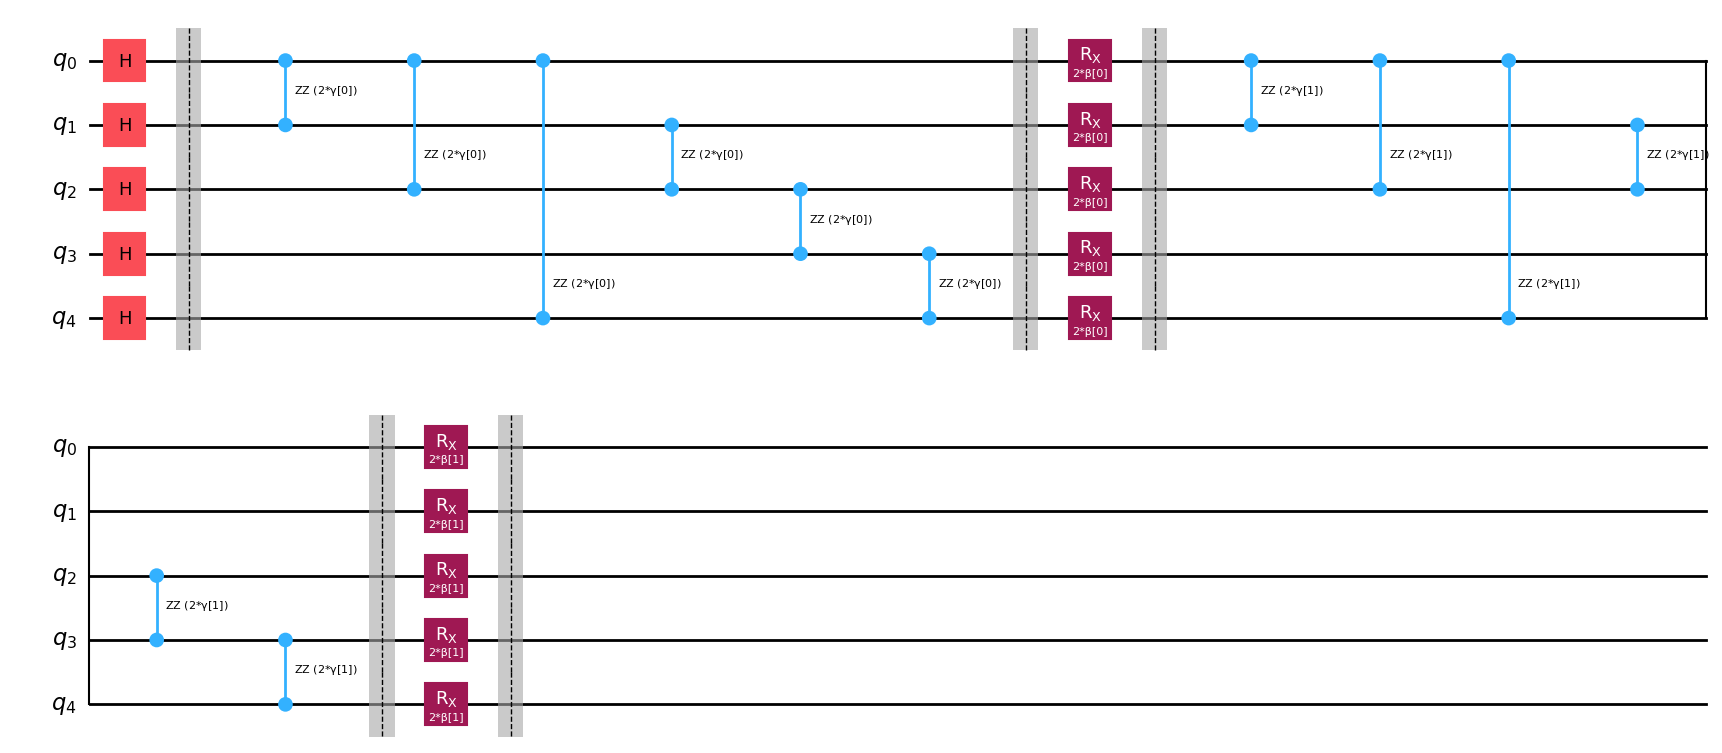

In [54]:
p = 2 # Number of layers
# Create a list of 2*p parameters (gammas and betas)
gammas = ParameterVector("γ", p)
betas  = ParameterVector("β", p)


def create_qaoa_ansatz(p, graph, gammas, betas):
    n = len(graph.nodes())
    qc = QuantumCircuit(n)
    
    # --- Your Code Here --- 
    
    # 1. Start in superposition
    qc.h(range(n))
    qc.barrier()
    
    # Loop through p layers
    for i in range(p):
        # 2. Apply Cost Layer U_P(gamma_i)
        for (u, v) in graph.edge_list():
            qc.rzz(2 * gammas[i], u, v)
        qc.barrier()
        
        # 3. Apply Mixer Layer U_M(beta_i)
        qc.rx(2 * betas[i], range(n))
        qc.barrier()
        
    # --- End Your Code --- 
    
    return qc

# Build and draw the ansatz for p=2
ansatz = create_qaoa_ansatz(p, graph, gammas, betas)
print(f"QAOA Ansatz with p={p} layers:")
ansatz.draw('mpl')

--- 

## Task 4: Run the Hybrid Loop

### 1. Engage (Why?)
We have the Hamiltonian ($H_P$) and the Ansatz ($U(\vec{\theta})$). Now we need to find the *best* $\vec{\theta}$. We will use a classical optimizer to "train" the circuit by running the hybrid loop.

### 2. Explain (The Concept)
We will use the **`COBYLA`** optimizer. 

In [46]:
# 4.A. Choose the Classical Optimizer
optimizer = COBYLA(maxiter=100)

# 4.B. Define the "Cost Function"
# This function is what the optimizer will call at each step
def cost_function(params_values, ansatz, hamiltonian, estimator):
    """Runs the ansatz and returns the measured cost."""
    # estimator.run() expects a list of circuits and a list of observables
    # or single objects. It returns a job.
    job = estimator.run([ansatz], [hamiltonian], parameter_values=[params_values])
    result = job.result()
    cost = result.values[0]
    return cost

print("Optimizer and Cost Function defined.")

Optimizer and Cost Function defined.


### 3. Elaborate (Apply)
**Your Task:** Run the optimization loop! We'll start the optimizer with a random initial guess for the parameters. We will wrap the `cost_function` so `COBYLA` can call it.

In [58]:
# --- Your Code Here --- 

# 1. Create an initial random guess for the parameters (gammas and betas)
np.random.seed(42) # for reproducibility
initial_point = np.random.rand(2 * p) #* 2 * np.pi # scale to [0, 2pi] to "search more areas of the cost function domain"

print(f"Running optimization for p={p} layers...")

# 2. Wrap the cost function
# This creates a function 'objective' that takes ONLY 'theta' as input,
# which is what COBYLA expects.
objective = lambda theta: cost_function(theta, ansatz, cost_hamiltonian, estimator)

# 3. Run the optimizer.minimize() function
opt_result = optimizer.minimize(
    fun=objective,          # The wrapped cost function
    x0=initial_point        # The initial parameter guess
)

print("\nOptimization complete.")
print(f"Best Cost Found: {opt_result.fun:.4f}")
print(f"Best Parameters (theta): {opt_result.x}")

best_params = opt_result.x

# --- End Your Code ---

Running optimization for p=2 layers...

Optimization complete.
Best Cost Found: -3.2469
Best Parameters (theta): [1.05353086 1.26172825 0.29252042 0.51428505]


**Analysis:** The optimizer should find a cost very close to **-4.0**, which we know is the energy of the *correct* solution. Now, let's find the bitstring that gives this cost.

--- 

## Task 5: Get and Verify the Final Solution

### 1. Engage (Why?)
The optimizer gives us the best *parameters* (angles), not the final bitstring. We must run our circuit one last time with these best parameters to find the solution.

### 2. Explain (The Concept)
Follwoing the concept from the notes, we now use the **`Sampler`** primitive. The `Sampler` runs the optimized circuit and returns the probabilities of measuring each bitstring. 

**Note:** The reference `Sampler` calculates exact quasi-probabilities by default (ideal simulation), so we do not need to specify a number of `shots`.

Sampling complete.


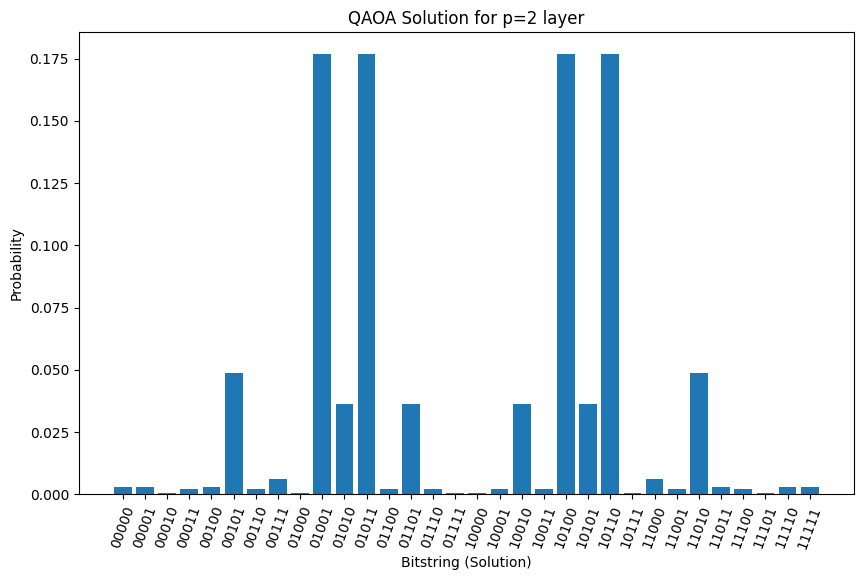

In [56]:
# --- Your Code Here --- 

# 1. Assign the best parameters to the ansatz
optimized_circuit = ansatz.assign_parameters(best_params)
# We need to measure the circuit to get bitstrings
optimized_circuit.measure_all()

# 2. Create a Sampler
sampler = Sampler()

# 3. Run the Sampler
job = sampler.run(optimized_circuit)
result = job.result()
counts = result.quasi_dists[0].binary_probabilities()

print("Sampling complete.")

# --- End Your Code ---

# 4. Plot the results
plt.figure(figsize=(10, 6))
plt.bar(counts.keys(), counts.values())
plt.xlabel("Bitstring (Solution)")
plt.ylabel("Probability")
plt.title(f"QAOA Solution for p={p} layer")
plt.xticks(rotation=70)
plt.show()

### 4. Evaluate (Final Verification)

Looking at the probability histogram, we observe four distinct bitstrings with the highest probabilities:
* `10100` and its bit-flipped pair `01011`
* `01001` and its bit-flipped pair `10110`

**Verification of 10100:**

This bitstring corresponds to placing Nodes 2 and 4 in one set (state $|1\rangle$) and Nodes 0, 1, and 3 in the other (state $|0\rangle$). Looking at our graph edges, this configuration cuts 5 out of 6 edges (only the edge between 0 and 1 is not cut).This yields the minimal energy of -4.0. The bit-flipped pair is the symmetry of our solutions, where the other peaks represent equivalent solutions. For example, `01011` is simply `10100` with all bits flipped (swapping the two sets), which produces the exact same cut value.


Initially, we just mentioned the simplest one solution of the problem. Through QAOA, we identified another possible solution which is `01001`. You may check that this solution are valid or not(cut the most edges too). This confirms that the QAOA algorithm successfully found the optimal solutions. However, if you noticed, it has a flaw in this coding task. The cost function does not necessarily approach to -4 because of shallow layer. Of course, you may try to approach larger layers for this exercise using QAOA methods. As for now, we only explore how it works and what is the results it produce.

**Conclusion:**

The high probabilities for these states confirm that our QAOA circuit (with $p=2$ layers and optimized parameters) successfully amplified the probability of measuring the optimal Max-Cut solutions.